In [40]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np

import boto3
from matplotlib import pyplot
%matplotlib inline

import os
import threading
import sys

In [3]:
!aws s3 ls wri-public-data/resourcewatch/raster/coral_reef_future_thermal_stress/

2017-10-04 10:01:47          0 
2017-10-04 10:29:39      46377 coral_2030.tif
2017-10-04 10:29:39      45724 coral_2050.tif


In [17]:
with rio.open("s3://wri-public-data/resourcewatch/raster/coral_reef_future_thermal_stress/coral_2030.tif") as src:
    out = "/Users/nathansuberi/Desktop/RW_Data/coral_2030_edit.tif"
    data_2030 = src.read(indexes=1)
    dst_crs = "EPSG:4326"
    
    print(src.profile)
    profile = src.profile
    
    dst_affine, dst_width, dst_height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    profile.update({
            'crs': dst_crs,
            'transform': dst_affine,
            'width': dst_width,
            'height': dst_height
        })

    with rio.open(out, 'w', **profile) as dst:
        src_array = src.read(indexes=1)
        dst_array = np.empty((dst_height, dst_width), dtype=src.profile["dtype"])

        reproject(
            # Source parameters
            source=data_2030,
            src_crs=src.crs,
            src_transform=src.transform,
            # Destination paramaters
            destination=dst_array,
            dst_transform=dst_affine,
            dst_crs=dst_crs,
            # Configuration
            resampling=Resampling.nearest,
            num_threads=2)

        dst.write(dst_array, indexes=1)


with rio.open("s3://wri-public-data/resourcewatch/raster/coral_reef_future_thermal_stress/coral_2050.tif") as src:
    out = "/Users/nathansuberi/Desktop/RW_Data/coral_2050_edit.tif"
    
    data_2050 = src.read(indexes=1)
    dst_crs = "EPSG:4326"
    
    print(src.profile)
    profile = src.profile
    
    dst_affine, dst_width, dst_height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
    
    profile.update({
            'crs': dst_crs,
            'transform': dst_affine,
            'width': dst_width,
            'height': dst_height
        })

    with rio.open(out, 'w', **profile) as dst:
        src_array = src.read(indexes=1)
        dst_array = np.empty((dst_height, dst_width), dtype=src.profile["dtype"])

        reproject(
            # Source parameters
            source=data_2050,
            src_crs=src.crs,
            src_transform=src.transform,
            # Destination paramaters
            destination=dst_array,
            dst_transform=dst_affine,
            dst_crs=dst_crs,
            # Configuration
            resampling=Resampling.nearest,
            num_threads=2)

        dst.write(dst_array, indexes=1)



{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 128.0, 'width': 802, 'height': 220, 'count': 1, 'crs': CRS({'proj': 'cea', 'lon_0': -160, 'lat_ts': 0, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}), 'transform': Affine(50000.0, 0.0, -20037507.067161843,
       0.0, -50000.0, 5508914.334533046), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 128.0, 'width': 802, 'height': 220, 'count': 1, 'crs': CRS({'proj': 'cea', 'lon_0': -160, 'lat_ts': 0, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}), 'transform': Affine(50000.0, 0.0, -20037507.067161843,
       0.0, -50000.0, 5508914.334533046), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


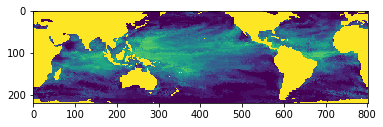

In [9]:
pyplot.imshow(data_2030)

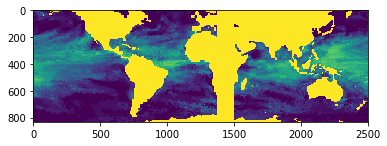

In [82]:
with rio.open("/Users/nathansuberi/Desktop/RW_Data/coral_2030_gdaledit.tif") as src:
    data_2030_gdaledit = src.read(indexes=1)
    pyplot.imshow(data_2030_gdaledit)

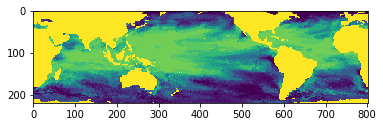

In [11]:
pyplot.imshow(data_2050)

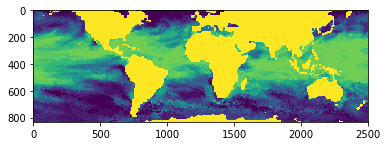

In [36]:
with rio.open("/Users/nathansuberi/Desktop/RW_Data/coral_2050_gdaledit.tif") as src:
    data_2050_rioedit = src.read(indexes=1)
    pyplot.imshow(data_2050_rioedit)

In [101]:
s3_upload = boto3.client("s3")
s3_download = boto3.resource("s3")

s3_bucket = "wri-public-data"
s3_folder = "resourcewatch/raster/bio_035_coral_reef_future_coral_bleaching_predictions/"

s3_file_2030 = "bio_035_coral_bleaching_predictions_2030.tif"
s3_file_2050 = "bio_035_coral_bleaching_predictions_2050.tif"

s3_key_orig_2030 = s3_folder + s3_file_2030
s3_key_orig_2050 = s3_folder + s3_file_2050
s3_key_edit_2030 = s3_key_orig_2030[0:-4] + "_edit.tif"
s3_key_edit_2050 = s3_key_orig_2050[0:-4] + "_edit.tif"

merge_file = "/Users/nathansuberi/Desktop/RW_Data/bio_035_coral_bleaching_predictions.tif"
s3_key_merge = s3_folder + "bio_035_coral_bleaching_predictions_merge.tif"

class ProgressPercentage(object):
        def __init__(self, filename):
            self._filename = filename
            self._size = float(os.path.getsize(filename))
            self._seen_so_far = 0
            self._lock = threading.Lock()

        def __call__(self, bytes_amount):
            # To simplify we'll assume this is hooked up
            # to a single filename.
            with self._lock:
                self._seen_so_far += bytes_amount
                percentage = (self._seen_so_far / self._size) * 100
                sys.stdout.write("\r%s  %s / %s  (%.2f%%)"%(
                        self._filename, self._seen_so_far, self._size,
                        percentage))
                sys.stdout.flush()

In [87]:
local_edit_2030 = "/Users/nathansuberi/Desktop/RW_Data/coral_2030_gdaledit.tif"
local_edit_2050 = "/Users/nathansuberi/Desktop/RW_Data/coral_2050_gdaledit.tif"

# Edit
s3_upload.upload_file(local_edit_2030, s3_bucket, s3_key_edit_2030,
                         Callback=ProgressPercentage(local_edit_2030))
# Edit
s3_upload.upload_file(local_edit_2050, s3_bucket, s3_key_edit_2050,
                         Callback=ProgressPercentage(local_edit_2050))

/Users/nathansuberi/Desktop/RW_Data/coral_2050_gdaledit.tif  285482 / 285482.0  (100.00%)

In [120]:
# Merge files
with rio.open(local_edit_2030) as src:
    profile = src.profile
    
band_names = [2030,2050]
profile.update(count=2, bands=band_names)

with rio.open(merge_file, "w", **profile) as dst:
    with rio.open(local_edit_2030) as src:
        data_2030 = src.read(indexes=1)
        dst.write(data_2030, indexes=1)
    with rio.open(local_edit_2050) as src:
        data_2050 = src.read(indexes=1)
        dst.write(data_2050, indexes=2)

In [121]:
with rio.open(merge_file) as src:
    print(src.profile)
    
# Edit
s3_upload.upload_file(merge_file, s3_bucket, s3_key_merge,
                         Callback=ProgressPercentage(merge_file))

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 128.0, 'width': 2499, 'height': 832, 'count': 2, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.14401960760088509, 0.0, -179.9997916753122,
       0.0, -0.1440772615670984, 60.068376780011235), 'bands': '[2030, 2050]', 'compress': 'lzw', 'interleave': 'band', 'tiled': False}
/Users/nathansuberi/Desktop/RW_Data/bio_035_coral_bleaching_predictions.tif  565455 / 565455.0  (100.00%)

In [104]:
s3_key_merge

'resourcewatch/raster/bio_035_coral_reef_future_coral_bleaching_predictions/bio_035_coral_bleaching_predictions_merge.tif'

In [122]:
os.environ["s3_key"] = "s3://" + s3_bucket + "/" + s3_key_merge
os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_merge
os.environ["asset_id"] = "users/resourcewatch/bio_035_coral_bleaching_predictions"

!gsutil cp $s3_key $gs_key

Copying s3://wri-public-data/resourcewatch/raster/bio_035_coral_reef_future_coral_bleaching_predictions/bio_035_coral_bleaching_predictions_merge.tif [Content-Type=binary/octet-stream]...
- [1 files][552.2 KiB/552.2 KiB]                                                
Operation completed over 1 objects/552.2 KiB.                                    


In [124]:
!earthengine upload image --asset_id=$asset_id $gs_key

Started upload task with ID: 6WAXFAWHKLFAYO7JFTUVP6RR


In [125]:
!earthengine task info 6WAXFAWHKLFAYO7JFTUVP6RR

6WAXFAWHKLFAYO7JFTUVP6RR:
  State: COMPLETED
  Type: Upload
  Description: Asset ingestion: users/resourcewatch/bio_035_coral_bleaching_predictions
  Created: 2017-10-04 14:58:59.952000
  Started: 2017-10-04 14:59:03.051000
  Updated: 2017-10-04 14:59:24.211000


In [126]:
os.environ["bandnames"] = str(band_names)
!earthengine asset set -p "(string)bandname=$bandnames" users/resourcewatch/bio_035_coral_bleaching_predictions